In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
plt.style.use("ggplot")
from ggplot import *
%matplotlib inline

In [2]:
df = pd.read_csv("data-2016-01-12.csv")
df2 = pd.read_csv("data-2016-01-13.csv")
df2.head()

,scheme,N,GPUs,i,htod,kernel,dtoh
0,cpall,1024,1,1,0.00228,0.00879,0.00353
1,cpall,1024,1,2,0.00281,0.00879,0.00331
2,cpall,1024,1,3,0.00320,0.00892,0.00364
3,cpall,1024,1,4,0.00315,0.00892,0.00368
4,cpall,2048,1,1,0.00720,0.07084,0.00858


In [3]:
df["i"] = 5
df.head(20)
cols = ["scheme", "N", "GPUs", "i", "htod", "kernel", "dtoh"]
df = df[cols]
df.head()

,scheme,N,GPUs,i,htod,kernel,dtoh
0,cpall,1024,1,5,0.00312,0.00892,0.00336
1,cpall,2048,1,5,0.00749,0.07081,0.00862
2,cpall,4096,1,5,0.02914,0.50653,0.02682
3,cpall,8192,1,5,0.11701,3.05843,0.07411
4,cpall,12288,1,5,0.19558,9.98749,0.16560


In [4]:
df3 = pd.concat([df, df2], ignore_index=True)
df3 = df3.sort_values(by=["GPUs","N","i"])
df3.head()

,scheme,N,GPUs,i,htod,kernel,dtoh
144,cpall,1024,1,1,0.00228,0.00879,0.00353
145,cpall,1024,1,2,0.00281,0.00879,0.00331
146,cpall,1024,1,3,0.00320,0.00892,0.00364
147,cpall,1024,1,4,0.00315,0.00892,0.00368
0,cpall,1024,1,5,0.00312,0.00892,0.00336


In [5]:
#df4 = pd.DataFrame(df3.values, index=range(0, np.shape(df3.values)[0]), columns=df3.columns)

grouped = df3.loc[:,["GPUs", "N", "htod", "kernel", "dtoh"]].groupby(["N", "GPUs"])
mFrame = grouped.transform(np.mean)
mFrame = pd.concat([mFrame, df3.loc[:,["GPUs", "N"]]], axis=1, join_axes=[mFrame.index])
mFrame["GFLOPs"] = mFrame.loc[:,["N", "kernel"]].apply(lambda x: x[0]**3 / x[-1] / 1e9, axis=1)
mFrame["kernel+cpys"]=mFrame.loc[:,["htod","kernel","dtoh"]].apply(lambda x: x[0] + x[1] + x[2], axis=1)
mFrame["speedup"] = mFrame.loc[:,["N", "kernel+cpys"]].apply(lambda x: mFrame[(mFrame.GPUs == 1) & (mFrame.N == x[0])].loc[:,["kernel+cpys"]].iloc[0,0] / x[1], axis=1)
mFrame.head()

,htod,kernel,dtoh,GPUs,N,GFLOPs,kernel+cpys,speedup
144,0.002912,0.008868,0.003504,1,1024,121.080494,0.015284,1
145,0.002912,0.008868,0.003504,1,1024,121.080494,0.015284,1
146,0.002912,0.008868,0.003504,1,1024,121.080494,0.015284,1
147,0.002912,0.008868,0.003504,1,1024,121.080494,0.015284,1
0,0.002912,0.008868,0.003504,1,1024,121.080494,0.015284,1


/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.1_1670.gc03262a-py2.7-linux-x86_64.egg/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


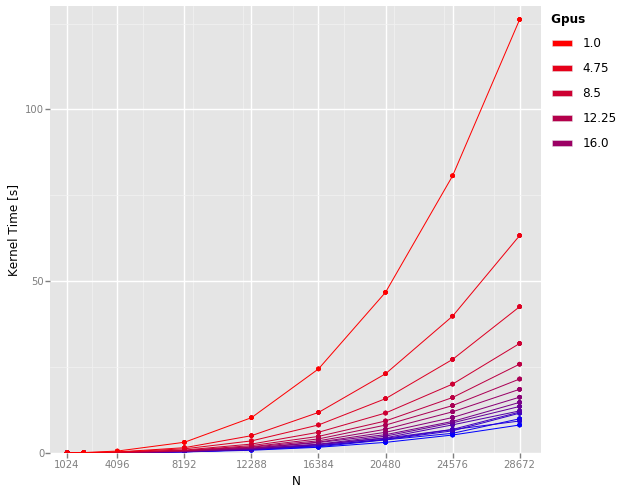

<ggplot: (8767633722265)>

In [6]:
p = ggplot(aes(x="N", y="kernel", color="GPUs"), data=mFrame) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("Kernel Time [s]") +\
xlim(0,30000) + ylim(0,130) + scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672])
p


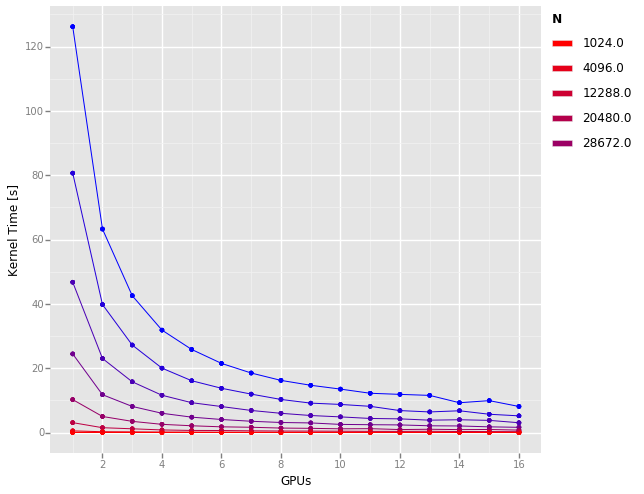

<ggplot: (8767633732637)>

In [7]:
p = ggplot(aes(x="GPUs", y="kernel", color="N"), data=mFrame) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("Kernel Time [s]")
#xlim(10.9,11.1) + ylim(4.25,4.45)
p

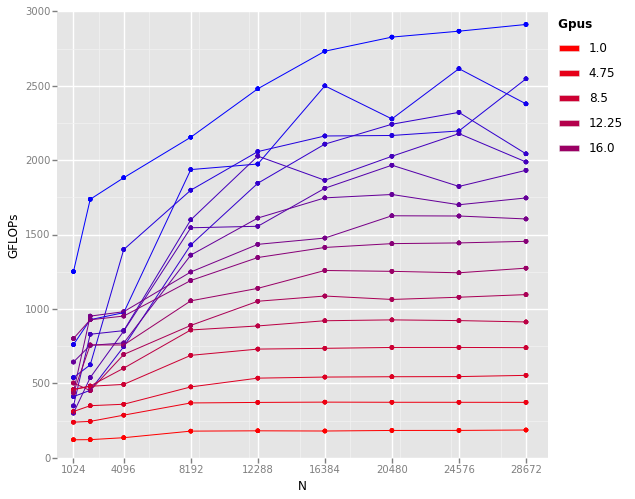

<ggplot: (8767633156721)>

In [8]:
p = ggplot(aes(x="N", y="GFLOPs", color="GPUs"), data=mFrame) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("GFLOPs") +\
xlim(0,30000) + ylim(0,3000) + scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672])
p

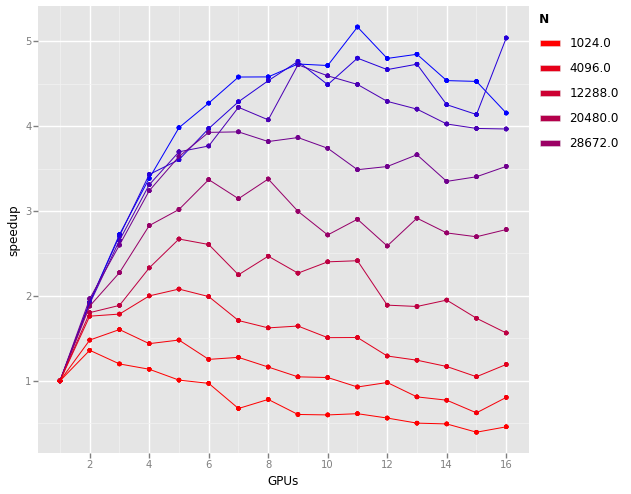

<ggplot: (8767633097949)>

In [9]:
p = ggplot(aes(x="GPUs", y="speedup", color="N"), data=mFrame) + geom_point() + geom_line()
p + scale_color_gradient(low="red", high="blue")

# Mat Mul Revisited with new Runtime
Moreover the used kernel has no use of shared memory. The time measurements are not available for N=28672 and one GPU because the slurm job time limit was exceeded.

In [10]:
dfn = pd.read_csv("../victoria_mat_mul_2016-08-03.csv")
dfn = dfn.groupby(["gpus","N"]).mean()
dfn = dfn.reset_index()
dfn["dep_res_time"] = dfn[["dep_res_creation_time", "dep_res_copy_time", "gpus"]].apply(lambda x : 0 if x[2] == 1 else x[0] + x[1], axis=1)
dfn["ratio_depres_usrkernel"] = dfn[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[0] / x[1], axis=1)
dfn["ratio_depres_copy"] = dfn[["dep_res_time", "dep_res_copy_time"]].apply(lambda x : x[1] / x[0], axis=1)
dfn["kernel_speedup"] = dfn.loc[:,["N", "usr_kernel_time"]].apply(lambda x: dfn[dfn.gpus == 1][dfn.N == x[0]].loc[:,["usr_kernel_time"]].iloc[0,0] / x[1], axis=1)
dfn["total_time"] = dfn[["usr_htod_memcpy_time", "usr_kernel_time", "usr_dtoh_memcpy_time"]].apply(lambda x : x[0] + x[1] + x[2], axis=1)
dfn["total_speedup"] = dfn.loc[:,["N", "total_time"]].apply(lambda x: dfn[dfn.gpus == 1][dfn.N == x[0]].loc[:,["total_time"]].iloc[0,0] / x[1], axis=1)
dfn["kernel-depres"] = dfn[["dep_res_time", "usr_kernel_time"]].apply(lambda x : x[1] - x[0], axis=1)
dfn["rel_dep_res_creation_time"] = dfn[["dep_res_time", "dep_res_creation_time"]].apply(lambda x : x[1] / x[0], axis=1)
dfn["rel_lin_time"] = dfn[["usr_dtoh_memcpy_time","lin_time"]].apply(lambda x: x[1]/x[0], axis=1)
dfn["dtoh_reduced_time"] = dfn[["usr_dtoh_memcpy_time","lin_time"]].apply(lambda x : x[0] - x[1], axis=1)
dfn.head(10)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,gpus,N,usr_htod_memcpy_time,usr_dtoh_memcpy_time,usr_kernel_time,dep_res_creation_time,dep_res_copy_time,arg_acc_time,lin_time,dep_res_time,ratio_depres_usrkernel,ratio_depres_copy,kernel_speedup,total_time,total_speedup,kernel-depres,rel_dep_res_creation_time,rel_lin_time,dtoh_reduced_time
0,1,1024,0.001425,0.000733,0.302536,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,0.304694,1.00000,0.302536,NaN,NaN,NaN
1,1,2048,0.005478,0.006451,1.795106,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,1.807035,1.00000,1.795106,NaN,NaN,NaN
2,1,4096,0.023354,0.009882,13.170100,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,13.203336,1.00000,13.170100,NaN,NaN,NaN
3,1,8192,0.089613,0.038252,104.250600,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,104.378465,1.00000,104.250600,NaN,NaN,NaN
4,1,12288,0.197322,0.086082,351.569400,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,351.852804,1.00000,351.569400,NaN,NaN,NaN
5,1,16384,0.315772,0.146216,832.140400,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,832.602387,1.00000,832.140400,NaN,NaN,NaN
6,1,20480,0.836247,0.252011,1624.460000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,1625.548258,1.00000,1624.460000,NaN,NaN,NaN
7,1,24576,1.223013,0.404201,2791.356000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,2792.983214,1.00000,2791.356000,NaN,NaN,NaN
8,1,28672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,1024,0.003308,0.012633,0.160308,0.000019,0,0.01175,0.011746,0.000019,0.000118,0,1.887217,0.176249,1.72877,0.160289,1,0.929755,0.000887


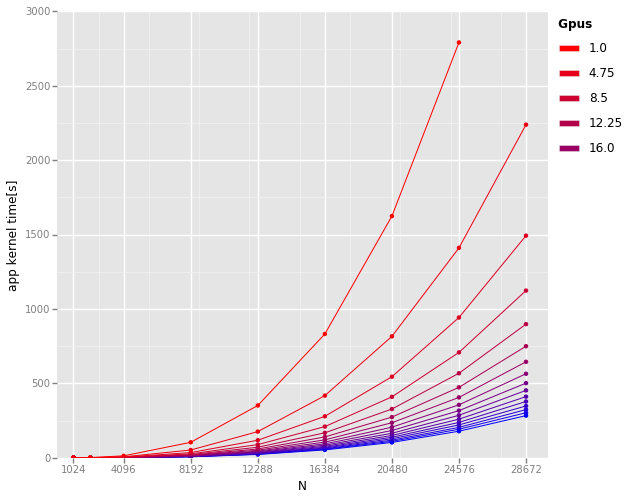

<ggplot: (8767633146813)>

In [11]:
p = ggplot(aes(x="N", y="usr_kernel_time", color="gpus"), data=dfn) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("app kernel time[s]") +\
xlim(0,30000) + ylim(0,3000) + scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672])
p

Creating two barplots...


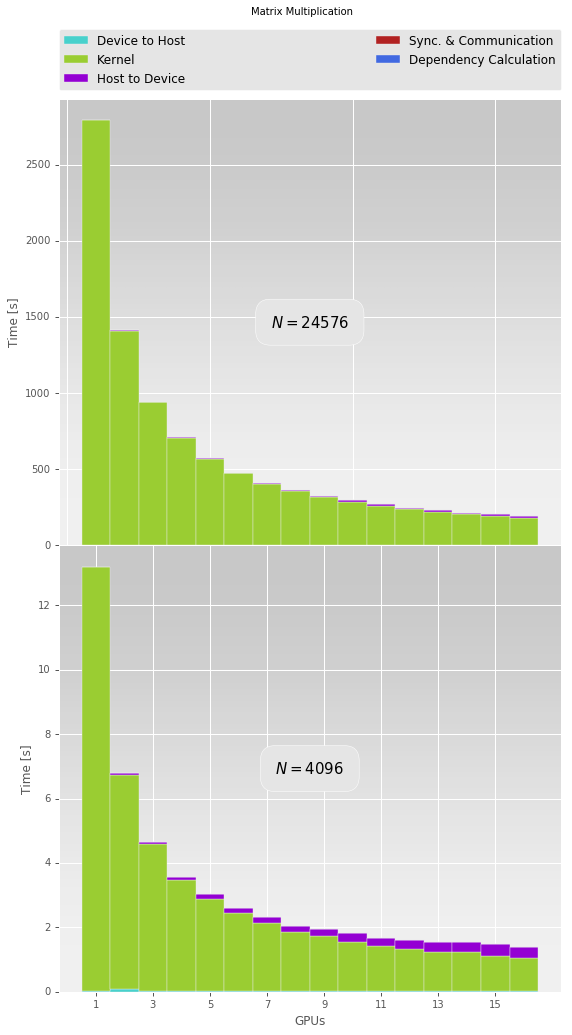

In [14]:
dummy = dfn[(dfn.N == 24576)].loc[:,["gpus","usr_dtoh_memcpy_time","usr_htod_memcpy_time", "kernel-depres","dep_res_copy_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

sm = ScalarMappable()
sm.set_clim(vmin = 0, vmax = 4)
cmName = "viridis"
sm.set_cmap(cmName)
width = 1
lw = 0.4


plt.style.use("ggplot")
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(211)
#colors = ["seagreen", "brown", "darkorange", "indigo"]
colors = ["yellowgreen", "darkviolet", "mediumturquoise", "firebrick", "royalblue"]

##### FIRST BARPLOT
print "Creating two barplots..."

ax.bar(dummy["GPUs"].values, dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax.bar(dummy["GPUs"].values, dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax.bar(dummy["GPUs"].values, dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax.bar(dummy["GPUs"].values, dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax.bar(dummy["GPUs"].values, dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_ticks_position("left")

#ax.set_xlim(0,17)
#ax.set_ylim(0, 175)
ax.set_ylabel("Time [s]")
#ax.set_xticks(range(2,numGpus+1,2))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x_text = abs(xlim[0] - xlim[1]) / 2.2 + xlim[0]
y_text = abs(ylim[0]  - ylim[1]) / 2.2 + ylim[0]
ax.text(0.5, 0.5, "$N=24576$", fontsize=15,\
        bbox={"facecolor":ax.get_facecolor(), "edgecolor":"white", "pad":1, "boxstyle":"round"},\
        horizontalalignment='center',\
        verticalalignment='center',\
        transform=ax.transAxes)

#### SECOND BARPLOT

dummy = dfn[(dfn.N == 4096)].loc[:,["gpus","usr_dtoh_memcpy_time","usr_htod_memcpy_time", "kernel-depres","dep_res_copy_time", "dep_res_creation_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Dependency Calculation"]

ax1 = fig.add_subplot(212)

ax1.bar(dummy["GPUs"].values, dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host", linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax1.bar(dummy["GPUs"].values, dummy["Kernel"].values, width = width, align="center",\
       label="Kernel", linewidth=lw, color=colors[0], bottom=cumu)
cumu += dummy["Kernel"].values
ax1.bar(dummy["GPUs"].values, dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device", bottom = cumu, linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax1.bar(dummy["GPUs"].values, dummy["Communication"].values, align="center", width=width,\
       label="Sync. & Communication", bottom = cumu, linewidth=lw, color=colors[3])
cumu += dummy["Communication"]
ax1.bar(dummy["GPUs"].values, dummy["Dependency Calculation"].values, align="center", width=width,\
       label="Dependency Calculation", bottom = cumu, linewidth=lw, color=colors[4])

ax1.get_xaxis().set_ticks_position("bottom")
ax1.get_yaxis().set_ticks_position("left")
ax1.grid(which="minor")
#ax1.set_xlim(0,17)
#ax1.set_ylim(0, 40)
#ax1.set_yticks(range(0,40,10))
ax1.set_ylabel("Time [s]")
ax1.set_xlabel("GPUs")
ax1.set_xticks(range(1,17,2))

ax1.text(0.5, 0.5, "$N=4096$", fontsize=15,\
        bbox={"facecolor":ax.get_facecolor(), "edgecolor":"white", "pad":1, "boxstyle":"round"},\
        horizontalalignment='center',\
        verticalalignment='center',\
        transform=ax1.transAxes)


legend = ax.legend(bbox_to_anchor=(0,1.02,1,0.102), loc=3, ncol=2, mode="expand",borderaxespad=0)
legend.get_frame().set_edgecolor("white")

## Background image
plotlim = ax.get_xlim() + ax.get_ylim()
ax.imshow([[1, 1], [0, 0]], cmap=plt.cm.Greys,vmin= -0.5, vmax= 4, interpolation="bicubic", extent=plotlim, aspect="auto")
plotlim = ax1.get_xlim() + ax1.get_ylim()
ax1.imshow([[1, 1], [0, 0]], cmap=plt.cm.Greys,vmin= -0.5, vmax= 4, interpolation="bicubic", extent=plotlim, aspect="auto")

fig.subplots_adjust(hspace=0,top=0.9)#, right=0.85)
fig.suptitle("Matrix Multiplication")
plt.show()
ax

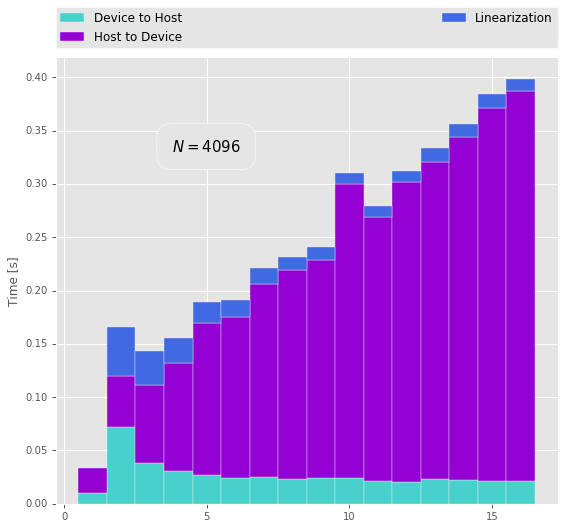

In [15]:
dummy = dfn[(dfn.N == 4096)].loc[:,["gpus","usr_dtoh_memcpy_time","usr_htod_memcpy_time", "kernel-depres","dep_res_copy_time", "lin_time"]]
dummy.columns = ["GPUs", "Device to Host", "Host to Device", "Kernel", "Communication", "Linearization"]

width = 1
lw = 0.4

plt.style.use("ggplot")
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)
#colors = ["seagreen", "brown", "darkorange", "indigo"]
colors = ["yellowgreen", "darkviolet", "mediumturquoise", "firebrick", "royalblue"]



ax.bar(dummy["GPUs"].values, dummy["Device to Host"].values, align="center", width=width,\
      label="Device to Host",linewidth=lw, color=colors[2])
cumu = dummy["Device to Host"].values
ax.bar(dummy["GPUs"].values, dummy["Host to Device"].values, align="center", width=width,\
       label="Host to Device",bottom=cumu,linewidth=lw, color=colors[1])
cumu += dummy["Host to Device"].values
ax.bar(dummy["GPUs"].values, dummy["Linearization"].values, align="center", width=width,\
       label="Linearization", bottom = cumu, linewidth=lw, color=colors[4])

ax.get_xaxis().set_ticks_position("bottom")
ax.get_yaxis().set_ticks_position("left")

#ax.set_xlim(0, numGpus + 1)
#ax.set_ylim(0, 0.07)
ax.set_ylabel("Time [s]")
#ax.set_xticks(range(2,numGpus+1,2))
ax.legend()
ax.text(0.3, 0.8, "$N=4096$", fontsize=15,\
        bbox={"facecolor":ax.get_facecolor(), "edgecolor":"white", "pad":1, "boxstyle":"round"},\
        horizontalalignment='center',\
        verticalalignment='center',\
        transform=ax.transAxes)

# LEGEND
legend = ax.legend(bbox_to_anchor=(0,1.02,1,0.102), loc=3, ncol=2, mode="expand",borderaxespad=0)
legend.get_frame().set_edgecolor("white")

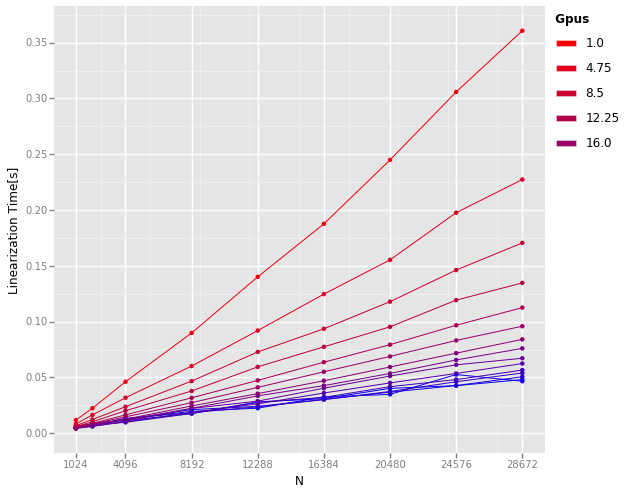

<ggplot: (8767630873449)>

In [16]:
p = ggplot(aes(x="N", y="lin_time", color="gpus"), data=dfn) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("Linearization Time[s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672]) 
#xlim(0,30000) + ylim(0,3000) 
p

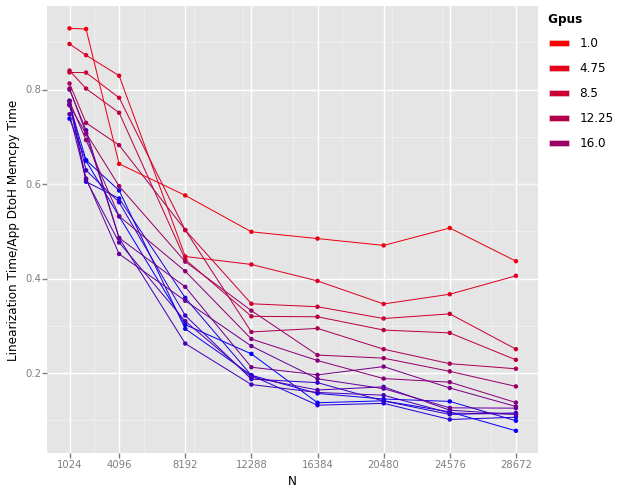

<ggplot: (8767630847737)>

In [17]:
p = ggplot(aes(x="N", y="rel_lin_time", color="gpus"), data=dfn) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("Linearization Time/App DtoH Memcpy Time") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672]) 
#xlim(0,30000) + ylim(0,3000) 
p

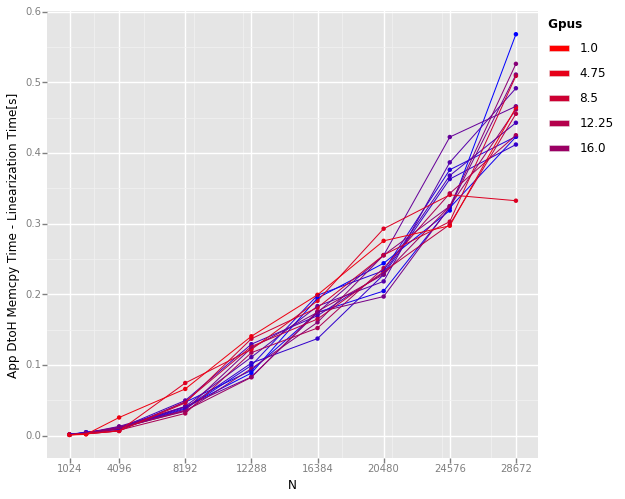

<ggplot: (8767630585093)>

In [18]:
p = ggplot(aes(x="N", y="dtoh_reduced_time", color="gpus"), data=dfn) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("App DtoH Memcpy Time - Linearization Time[s]") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672]) 
#xlim(0,30000) + ylim(0,3000) 
p

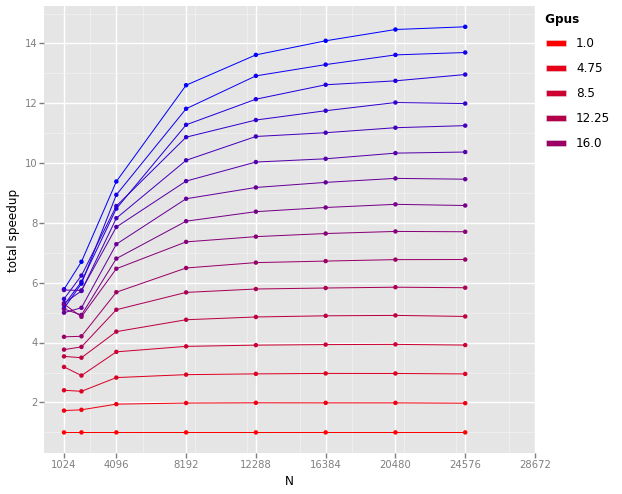

<ggplot: (8767633137977)>

In [20]:
p = ggplot(aes(x="N", y="total_speedup", color="gpus"), data=dfn) +\
geom_point(size=20) + geom_line() +\
scale_color_gradient(low="red", high="blue") + ylab("total speedup") +\
scale_x_continuous(breaks=[1024,4096,8192,12288,16384,20480,24576,28672])
#xlim(0,25000) + ylim(0,15)
p